# Gömb illesztés RANSAC eljárással

Az [előzőekben](https://nbviewer.jupyter.org/github/gyulat/RANSAC-examples/blob/master/Sphfit.ipynb) már megvizsgáltuk a gömbillesztés problémájának megoldását legkisebb négyzetek módszerével. A gyakorlatban azonban sokszor olyan adataink vannak, amelyek nagy százalékban tartalmaznak durva hibás, azaz kivágó (outlier) értékeket. Kiváló módszert adtak [Fischler és Bolles](http://www.cs.columbia.edu/~belhumeur/courses/compPhoto/ransac.pdf) az ilyen adatokból történő paraméterbecslésre 1981-es cikkükben, amely jól alkalmazható a mi problémánkra is.

Ahogy azt már az [ellipszis illesztési feladatnál](https://nbviewer.jupyter.org/github/gyulat/RANSAC-ellipse/blob/master/RANSAC_ellipszis.ipynb) láttuk, a RANSAC módszer a következő lépésekből áll:

1. Állítsunk elő egy előre meghatározott $M$ számú modellt (hipotézist), mindegyiket a modell egyértelmű megalkotásásához szükséges minimális $n$ darab adat alapján (ez a modell paraméterek meghatározását jelenti)
2. Értékeljük ki mindegyik modellt (hipotézist):
   * számítsuk ki az összes adat illeszkedési eltéréseit a modellhez képest
   * egy adott hibaküszöbön belüli adatok alkotják a konform adathalmazt (ún. „konszenzus” halmazt) 
3. Azt a modellt (hipotézist) választjuk, amelynek konform (konszenzus) halmaza a legtöbb elemből áll (ez az eredeti RANSAC módszerben alkalmazott kritérium)

A RANSAC eljárás alkalmazásához tehát rendelkeznünk kell a következő algoritmusokkal (függvényekkel):
* modell létrehozása a minimálisan szükséges $n$ adat alapján
* illeszkedési eltérések számítása egy adott modellhez képest

A gömbillesztési probléma esetében már megírtuk ezeket a függvényeket, így csak be kell integrálnuk őket a [scikit-image](http://scikit-image.org/) eljáráskönyvtárban található [ransac](http://scikit-image.org/docs/stable/api/skimage.measure.html?highlight=ransac#skimage.measure.ransac) függvénybe.

A függvény leírásából kiderül, hogy a 
```python
import skimage.measure as sm

sm.ransac(data, model_class, min_samples, residual_threshold) 
```
függvénynek négy kötelező paramétere van. 
1. Az adatok  `data(N, D)` méretű tömbje, ahol `N` az adatok száma, `D` az adatok dimenziója,
2. a modellt megvalósító Python osztály (class), aminek kötelező tagfüggvényei a `success = estimate(*data)` és a `residuals(*data)`,
3. a `min_samples` egész szám, ami az előzőekben említett $n$.
4. a `residual_threshold`, a leírás alapján az adatpontnak az a maximális távolsága, amíg még konform, a modellhez illeszkedő adatnak számít.




### A SphereModel Python osztály

A RANSAC eljáráshoz a mi esetünkben szükséges osztályt (`SphereModel`) egy egyszerű konstruktor és a két szükséges tagfüggvény alkotja. A függvény használja a korábbi `svdsolve` függvényt, így annak a kódja is szerepel. A `params` tagváltozó a meghatározott gömb paramétereit (középpont és sugár) tárolja.

In [1]:
class SphereModel:
    """sphere fitting model 
    """

    def __init__(self):
        self.params = np.zeros(4)

    def estimate(self, X):
        """
        estimate(X) gömböt határoz meg négy vagy több, az, X mátrix soraiban megadott pontra
        Hivatkozás: Paláncz, Molnár (2012): Fitting sphere to quantized depth information
        Input:  X: nx3-as mátrix, az n pont [x,y,z] koordinátái (sorvektorokként tárolva)
        Eredmény: paraméter 4 elemű vektorban  params: [x0, y0, z0, r], ahol:
                  r: a gömb sugara
                  x0, y0, z0: a gömb középpontjának koordinátái
        Megjegyzés:  Ha nincs jó megoldás, akkor a függvény visszatérési értéke False
        """

        # átlagértékeket levonjuk
        Xm = np.mean(X,axis=0)
        Xs = X-Xm
        n = Xs.shape[0]

        # M mátrix
        M=np.hstack((-2.0*Xs,np.ones((n,1))))
        # h vektor
        h=-np.sum(Xs**2,axis=1)  # sorok összegzése
        # kondíciószám ellenőrzése:
        if np.linalg.cond(M) > 1000:
            return False
        self.params=svdsolve(M,h)
        # gömb sugara
        r=np.sqrt(np.sum(self.params[0:3]**2)-self.params[3])
        self.params[3]=r
        # középpont koordinátái
        self.params[0:3] = self.params[0:3]+Xm
        return True
    
    def residuals(self, X, pos=1):
        """
        residuals(X) az X pontok távolságát számítja ki a sph gömbtől
        params: 4-elemű vektor: [x0, y0, z0, r]
             x0, y0, z0: a gömb középpontja
             r: a gömb sugara
             X: (n,3) mátrix, az n db. pont koordinátái
           pos: ha pos=0, előjeles távolságokat számít ki, egyébként nem
        """
        r = self.params[3]
        c = self.params[0:3]
        # középponttól vett távolság négyzete
        dc = np.sum((X-c)**2,axis=1)
        if pos==1:
            dist = np.abs(np.sqrt(dc)-r)
        else:
            dist = np.sqrt(dc)-r
        return dist
    
def svdsolve(a,b):
    u,s,v = np.linalg.svd(a)
    c = np.dot(u.T,b)
    w = np.divide(c[:len(s)],s)
    x = np.dot(v.T,w)
    return x

### Teszt adatok

Az alábbi teszt [adatokat](./dat/sphere.dat) használjuk fel (lézerszkenneres referencia gömb mérés, [Rehány Nikolett][rn]-től kapott adatok). A beolvasott pontfelhő így néz ki:
[rn]: http://www.epito.bme.hu/rehany-nikolett

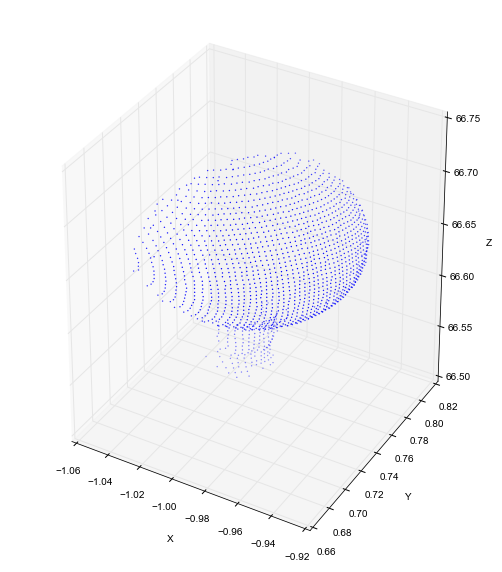

In [4]:
%matplotlib inline
import numpy as np
import skimage.measure as sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## teszt adatok (1581 pont)
X1=np.loadtxt("./dat/sphere.dat")

## kirajzoljuk
width=10; height=10
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(111, aspect='equal', projection='3d')
ax.scatter(X1[:,0], X1[:,1], X1[:,2], edgecolors='none', s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


Az adatok beolvasása után elvégezzük a gömb RANSAC becslését. Az esetünkben a `min_samples = 4`. A `residual_threshold` értékét nem vehetjük se túl nagyra, se túl kicsire. Némi próbálkozás után pl. a `0.003` értéket találhatjuk célszerűnek.

In [8]:
ransac_model, inliers = sm.ransac(X1, SphereModel, 4, 0.003)

np.set_printoptions(suppress=True)
print ransac_model.params
print "pontok száma : ", X1.shape[0]
print "kivágó pontok: ", X1.shape[0]-np.sum(inliers)

[ -1.0067282    0.75263481  66.65209555   0.06952197]
pontok száma :  1581
kivágó pontok:  156


Ha az előző számítást többször egymás után megismételjük, akkor azt tapasztalhatjuk, hogy minden esetben kissé változnak a becsült paraméterek és a kivágó pontok száma. Ez a RANSAC módszer véletlen jellegéből fakad - az eredmény függ az adott próbálkozástól.

Rajzoljuk fel a kapott konszenzus halmazt és a kivágó pontokat:

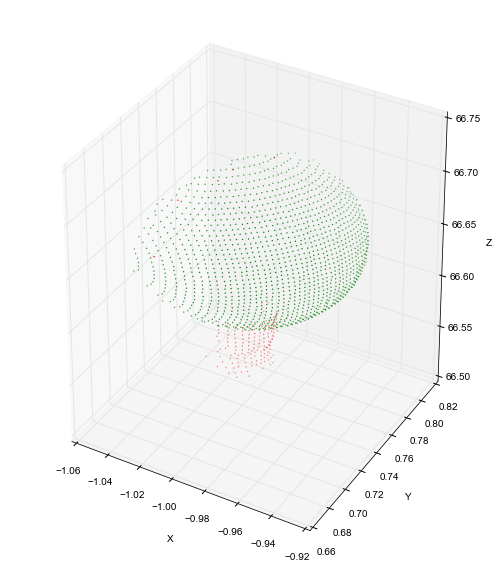

In [9]:
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(111, aspect='equal', projection='3d')
ax.scatter(X1[inliers,0], X1[inliers,1], X1[inliers,2], edgecolors='none', c='green',s=2)
outliers = np.invert(inliers)
ax.scatter(X1[outliers,0], X1[outliers,1], X1[outliers,2], edgecolors='none', c='red',s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Illeszkedési eltérések
Rajzoljuk ki az illeszkedési eltérések hisztogramját

átlag:    -0.00 %
szórás:    0.72 %
max:       5.49 %


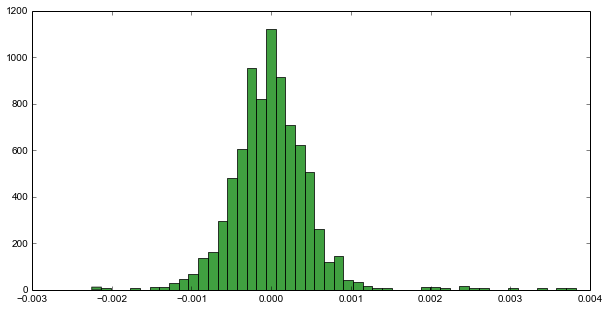

In [11]:
def sphdist(sph,X,pos=1):
    """
    sphdist(sph,X) az X pontok távolságát számítja ki a sph gömbtől
    sph: 4-elemű vektor: [x0, y0, z0, r]
         x0, y0, z0: a gömb középpontja
         r: a gömb sugara
         X: (n,3) mátrix, az n db. pont koordinátái
       pos: ha pos=0, előjeles távolságokat számít ki, egyébként nem
    """
    r = sph[3]
    c = sph[0:3]
    # középponttól vett távolság négyzete
    dc = np.sum((X-c)**2,axis=1)
    if pos==1:
        dist = np.abs(np.sqrt(dc)-r)
    else:
        dist = np.sqrt(dc)-r
    return dist

# előjeles távolságokat számítunk
v = sphdist(ransac_model.params,X1[inliers,:],0)

# sugárhoz viszonyított százalékos eltérések
print "átlag:  %7.2f" % (100*np.mean(v)/ransac_model.params[3]) + " %"
print "szórás: %7.2f" % (100*np.std(v)/ransac_model.params[3]) + " %"

# max. százalékos eltérés
print "max:    %7.2f" % (100*np.max(np.abs((v)))/ransac_model.params[3]) + " %"

# relatív eltérsek hisztogramja
fig = plt.figure(figsize=(width, height/2))
n, bins, patches = plt.hist(v, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()

### Kvantilis-kvantilis ábra (Q-Q plot)

A normalitás vizsgálatához használjunk normális kvantilis-kvantilis ábrát.

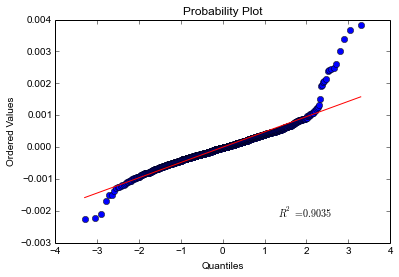

In [12]:
import scipy.stats as stats

stats.probplot(v, dist="norm", plot=plt)
plt.show()

### További lehetőségek

A RANSAC becslésnek sokféle változata alakult ki az évek során. Ezek pl. a MSAC, MLESAC, KALMANSAC és társaik. Érdekes lenne kipróbálni a különféle változatokat és összehasonlítani a kapott eredményeket.